In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [283]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [284]:
data = pd.read_csv('final-data.csv')

In [285]:
data['Week Endings'] = pd.to_datetime(data['Week Endings'], errors = 'raise')
data = data.sort_values(by='Week Endings', ascending=True)

In [286]:
# Truncating data after the release of the lion king movie
lk_release = datetime.date(2019, 7, 19)
boolean_mask = data['Week Endings'].dt.date < lk_release

In [287]:
# Data after the series has been truncated
print(data[boolean_mask].tail(5).to_string())
print(data[boolean_mask].shape)

    Week Endings  Avg Ticket Price ($)  Top Ticket Price ($)  Seats Sold  Seats in Theatre   % Cap
141   2019-06-16                171.79                 225.0       13565              1696   99.98
140   2019-06-23                178.53                 225.0       13569              1696  100.01
139   2019-06-30                179.18                 225.0       13550              1696   99.87
138   2019-07-07                190.91                 225.0       13519              1696   99.64
137   2019-07-14                187.67                 225.0       12759              1696   94.04
(1129, 6)


In [288]:
data = data[boolean_mask]

In [289]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1129 entries, 1265 to 137
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Week Endings          1129 non-null   datetime64[ns]
 1   Avg Ticket Price ($)  1129 non-null   float64       
 2   Top Ticket Price ($)  1129 non-null   float64       
 3   Seats Sold            1129 non-null   int64         
 4   Seats in Theatre      1129 non-null   int64         
 5   % Cap                 1129 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 61.7 KB


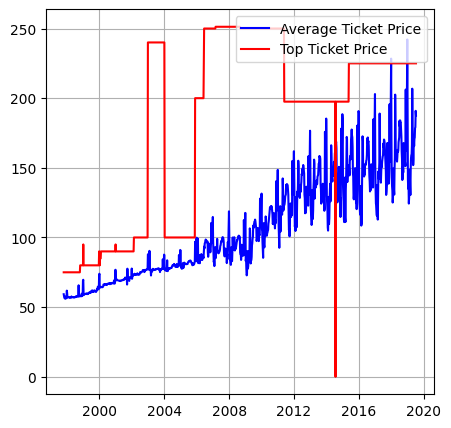

In [290]:
# Some basic plotting to check data and 
# data scale to determine whether data needs to be normalised or not
# before being used with the sequence model for prediction
# year = np.array(range(data.shape[0])) + 757
time = data['Week Endings']
plt.figure(figsize=(5, 5))
plt.grid(True)
plt.plot(time, data['Avg Ticket Price ($)'], color='b', label="Average Ticket Price")
plt.plot(time, data['Top Ticket Price ($)'], color='r', label="Top Ticket Price")
plt.legend(loc=1)
plt.show()

In [291]:
series = data['Avg Ticket Price ($)']
split_time = int(len(series) * 0.85)

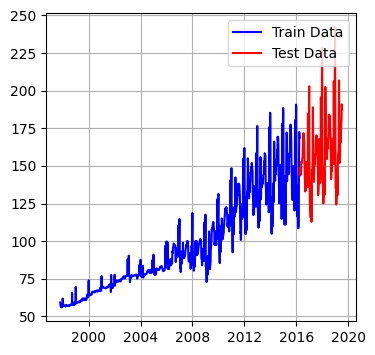

In [292]:
x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

plt.figure(figsize=(4, 4))
plt.grid(True)
plt.plot(time_train, x_train, color='b', label="Train Data")
plt.plot(time_valid, x_valid, color='r', label="Test Data")
plt.legend(loc=1)
plt.show()

# Utilities:

In [293]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [314]:
# Defining parameters
window_size = 20
batch_size = 4
shuffle_buffer = 1000

In [315]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [316]:
# Checking the windowed training set:
list(train_set.take(2).as_numpy_iterator())

[(array([[143.01, 114.38, 111.11, 134.29, 140.89, 152.97, 172.18, 170.67,
          139.79, 145.52, 147.51, 148.24, 145.59, 151.94, 149.28, 144.55,
          155.76, 158.44, 155.9 , 157.56],
         [ 80.96,  79.37,  79.41,  78.79,  79.99,  79.96,  79.81,  87.42,
           80.62,  80.67,  79.82,  91.04,  90.81,  79.86,  79.43,  77.85,
           78.55,  77.6 ,  78.35,  80.25],
         [ 85.15,  85.15,  86.19,  85.16,  93.44,  92.12,  95.79,  96.24,
           97.22,  98.55,  98.08,  98.08,  96.79,  96.53,  96.35,  97.08,
           88.95,  86.15,  88.34,  92.69],
         [101.26, 102.99, 103.7 , 104.85, 105.42, 109.95, 111.49, 113.86,
          115.59, 117.98, 121.74, 120.96, 120.53, 122.44, 121.93, 122.44,
          121.61, 119.28, 116.66, 109.78]]),
  array([170.32,  81.66,  95.52, 110.77])),
 (array([[ 96.93,  83.44,  84.54,  84.58,  98.39,  99.83,  84.44,  83.67,
           82.46,  99.1 ,  81.57,  82.67,  85.42,  87.42,  83.74,  81.5 ,
           84.55,  85.71,  85.11,  84.21],

In [317]:
# Creating the validation dataset
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer)

In [372]:
# Resetting any prior defined model weight data
tf.keras.backend.clear_session()

# Defining the model
l0 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
    l0
])

In [373]:
print(l0.get_weights())

[array([[ 0.01599914],
       [ 0.18170333],
       [-0.26329702],
       [-0.46209282],
       [-0.70072454],
       [ 0.24096501],
       [ 0.02991223],
       [ 0.49113256],
       [-0.5666686 ],
       [ 0.24480683]], dtype=float32), array([0.], dtype=float32)]


In [374]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.4),
    metrics=['mae'])

In [375]:
# Training Parameters
epochs = 100

In [376]:
# Learning Rate Scheduler (Exponential Decay)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * (10 ** (epoch / 20))
)

In [377]:
history = model.fit(train_set, epochs=epochs, validation_data=valid_set)

Epoch 1/100


235/235 [==============================] - 2s 4ms/step - loss: 13.6111 - mae: 14.0817 - val_loss: 20.1613 - val_mae: 20.6495
Epoch 2/100
235/235 [==============================] - 0s 2ms/step - loss: 7.3307 - mae: 7.7989 - val_loss: 19.0636 - val_mae: 19.5623
Epoch 3/100
235/235 [==============================] - 0s 2ms/step - loss: 7.0049 - mae: 7.4782 - val_loss: 18.1215 - val_mae: 18.6154
Epoch 4/100
235/235 [==============================] - 0s 2ms/step - loss: 6.6138 - mae: 7.0823 - val_loss: 17.2505 - val_mae: 17.7478
Epoch 5/100
235/235 [==============================] - 0s 2ms/step - loss: 6.4050 - mae: 6.8736 - val_loss: 16.3749 - val_mae: 16.8709
Epoch 6/100
235/235 [==============================] - 0s 2ms/step - loss: 6.1776 - mae: 6.6446 - val_loss: 16.1297 - val_mae: 16.6261
Epoch 7/100
235/235 [==============================] - 0s 2ms/step - loss: 6.0550 - mae: 6.5188 - val_loss: 16.0904 - val_mae: 16.5851
Epoch 8/100
235/235 [==============================] - 0s 2ms/ste

In [378]:
hist = history.history
loss = hist['loss']
val_loss = hist['val_loss']
mae = hist['mae']
val_mae = hist['val_mae']
epoch_life = range(len(loss))

In [379]:
# # Learning Rate Scheduler plot
# lr = hist['lr']
# plt.semilogx(lr[0:40], loss[0:40])
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.title("Learning Rate Scheduler Helper")
# plt.grid(True)
# plt.show()

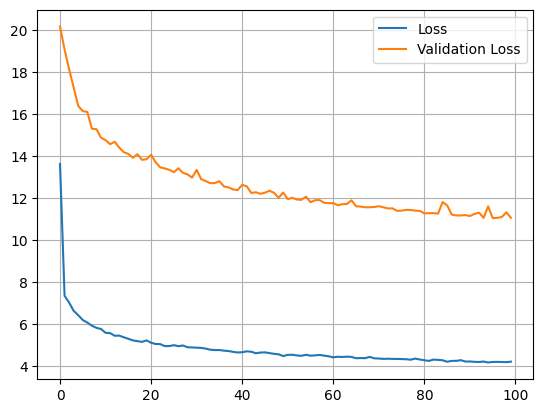

In [380]:
plt.plot(epoch_life, loss, label="Loss")
plt.plot(epoch_life, val_loss, label="Validation Loss")
plt.legend(loc=1)
plt.grid(True)
plt.show()

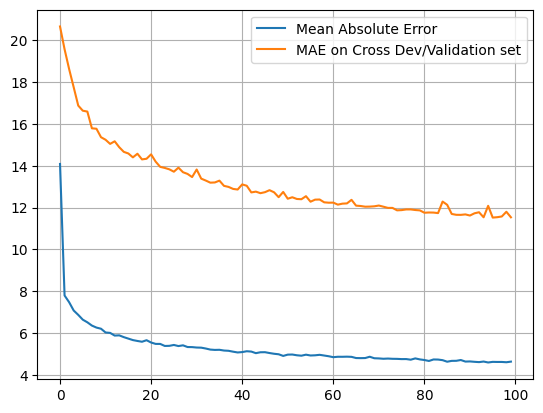

In [381]:
plt.plot(epoch_life, mae, label="Mean Absolute Error")
plt.plot(epoch_life, val_mae, label="MAE on Cross Dev/Validation set")
plt.grid(True)
plt.legend(loc=1)
plt.show()

In [382]:
# Checking layer weights:
print(l0.get_weights())

[array([[ 0.01599914],
       [ 0.2021025 ],
       [-0.26329702],
       [-0.46209282],
       [-0.68574405],
       [ 0.08327113],
       [ 0.18963161],
       [ 0.34339708],
       [-0.58852774],
       [ 0.24480683]], dtype=float32), array([-0.00107572], dtype=float32)]


In [383]:
series = np.array(series)

In [384]:
# Checking out by forecasting for 1 window
start = split_time - window_size
output = model.predict(series[start:split_time][np.newaxis])
print("Actual Price: ${}".format(series[split_time]))
print("Predicted Price: ${}".format(output.squeeze()))

1/1 [==============================] - 0s 51ms/step
Actual Price: $148.38
Predicted Price: $141.34140014648438


In [385]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

In [386]:
series_to_forecast = series[split_time-window_size:-1]
forecast = model_forecast(model, series_to_forecast, window_size, batch_size)
forecast = np.squeeze(forecast)

43/43 [==============================] - 0s 1ms/step


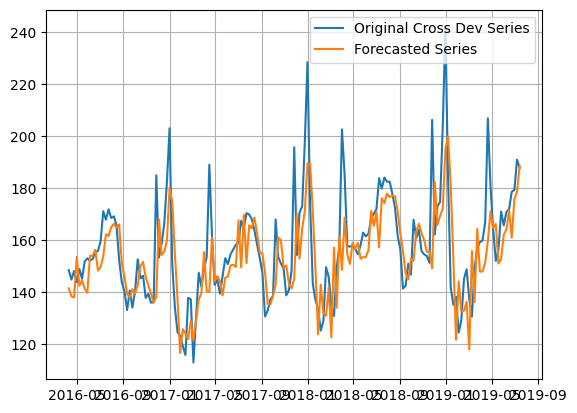

Mean Absolute Error for Forecasted Series: 11.002620697021484


In [387]:
plt.plot(time_valid, x_valid, label="Original Cross Dev Series")
plt.plot(time_valid, forecast, label="Forecasted Series")
plt.legend(loc=1)
plt.grid(True)
plt.show()

print("Mean Absolute Error for Forecasted Series: {}".format(tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()))

### Chores: 
To perform sanity check, normalize data, and optionally set a benchmark for the model using statistical methods